In [27]:
# Import dependencies
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pathlib
import PIL
import PIL.Image
import cv2

from tqdm import tqdm

In [2]:
# Lets check your GPU
if tf.config.list_logical_devices('GPU') != []:
    print("LET'S DO THISS!!! :DDDD")
else: 
    print("Oh dude... D:")

LET'S DO THISS!!! :DDDD


In [3]:
'''

Lets define some dir to save iamges.

'''

from pathlib import Path

IMAGES_PATH = Path() / "images" / "generative"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [4]:
path = "./img_align_celeba"
data_dir = pathlib.Path(path)

# Lets check quantity
image_count = len(list(data_dir.glob('*.jpg')))
print('We have', image_count, 'images.')

We have 202599 images.


In [5]:
# Get all paths
all_paths = [str(x) for x in list(data_dir.glob('*.jpg'))]

In [6]:
train_path = all_paths[:int(image_count * 0.8)]
val_path = all_paths[int(image_count * 0.8): int(image_count * 0.9)]
test_path = all_paths[int(image_count * 0.9):]

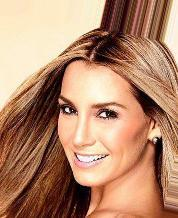

In [7]:
# Sanity check!
PIL.Image.open(train_path[0])

In [8]:
# Instanciate tf datasets
ds_train_path = tf.data.Dataset.from_tensor_slices(train_path)
ds_val_path = tf.data.Dataset.from_tensor_slices(val_path)
ds_test_path = tf.data.Dataset.from_tensor_slices(test_path)

In [34]:
'''

Open all images and resize.

'''

def open_image(x):
    return tf.ensure_shape(tf.image.decode_image(tf.io.read_file(x)), [218, 178, 3])

def resize_image(x, n_outputs=1):
    if n_outputs == 2:
        return (tf.image.resize(x, [128, 128]) / 255., tf.image.resize(x, [128, 128]) / 255.)
    return tf.image.resize(x, [128, 128]) / 255.

ds_train = ds_train_path.map(
    lambda x: resize_image(open_image(x))
)

ds_val = ds_val_path.map(
    lambda x: resize_image(open_image(x))
)

ds_test = ds_test_path.map(
    lambda x: resize_image(open_image(x))
)

In [10]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean 

In [11]:
from functools import partial

DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="same", kernel_initializer="he_normal",
                        use_bias=False)

DefaultDeConv2D = partial(tf.keras.layers.Conv2DTranspose, kernel_size=3, strides=2,
                          padding="same", kernel_initializer="he_normal",
                          use_bias=False)

class ResidualUnit(tf.keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            tf.keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            tf.keras.layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                tf.keras.layers.BatchNormalization()
            ]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)
    
class ResidualDeConvUnit(tf.keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)
        self.main_layers = [
            DefaultDeConv2D(filters, strides=strides),
            tf.keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            tf.keras.layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultDeConv2D(filters, kernel_size=1, strides=strides),
                tf.keras.layers.BatchNormalization()
            ]
        
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [12]:
codings_size = 256
inputs = tf.keras.layers.Input(shape=[128, 128, 3])
# Z = keras.layers.Reshape([128, 128, 1])(inputs)
Z = DefaultConv2D(64, kernel_size=3, strides=2)(inputs)
Z = keras.layers.Activation("relu")(Z)
Z = keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same")(Z)

prev_filters = 64
for filters in [64] * 1 + [128] * 2 + [256] * 2 + [512] * 1:
    strides = 1 if filters == prev_filters else 2
    Z = ResidualUnit(filters, strides=strides)(Z)
    prev_filters = filters

Z = keras.layers.GlobalAvgPool2D()(Z)
Z = keras.layers.Flatten()(Z)

codings_mean = tf.keras.layers.Dense(codings_size)(Z)  # μ
codings_log_var = tf.keras.layers.Dense(codings_size)(Z)  # γ
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = tf.keras.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

In [13]:
variational_encoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 64)   1728        ['input_1[0][0]']                
                                                                                                  
 activation (Activation)        (None, 64, 64, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 32, 32, 64)   0           ['activation[0][0]']         

In [23]:
decoder_inputs = tf.keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(4 * 4 * (512))(decoder_inputs)
x = keras.layers.Reshape((4, 4, 512))(x)
x = keras.layers.Conv2DTranspose(512, 3, padding='same', activation='relu')(x)
x = keras.layers.UpSampling2D(2)(x)
prev_filters = 512
for filters in ([64] * 1 + [128] * 2 + [256] * 2 + [512] * 1)[::-1]:
    strides = 1 if filters == prev_filters else 2
    x = ResidualDeConvUnit(filters, strides=strides)(x)
    prev_filters = filters

x = keras.layers.Conv2DTranspose(32, 3, padding='same', activation='relu')(x)
x = keras.layers.UpSampling2D(2)(x)
x = keras.layers.Conv2DTranspose(3, 3, padding='same', activation='sigmoid')(x)
outputs = keras.layers.Reshape([128, 128, 3])(x)
variational_decoder = tf.keras.Model(inputs=[decoder_inputs], outputs=[outputs])

In [24]:
variational_decoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 256)]             0         
                                                                 
 dense_11 (Dense)            (None, 8192)              2105344   
                                                                 
 reshape_18 (Reshape)        (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_108 (Conv2  (None, 4, 4, 512)        2359808   
 DTranspose)                                                     
                                                                 
 up_sampling2d_12 (UpSamplin  (None, 8, 8, 512)        0         
 g2D)                                                            
                                                                 
 residual_de_conv_unit_54 (R  (None, 8, 8, 512)        4722

In [25]:
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = tf.keras.Model(inputs=[inputs], outputs=[reconstructions])

In [26]:
latent_loss = -0.5 * tf.reduce_sum(
    1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean),
    axis=-1)
variational_ae.add_loss(tf.reduce_mean(latent_loss) / (128.0 * 128.0))

In [31]:
from IPython.display import clear_output
def plot_multiple_images(images, n_cols=None, k=1):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols * k, n_rows * k))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        clear_output()
        plt.axis("off")
        
def plot_losses(history):
    epochs = np.array(list(range(1, len(history['loss_reconstruction']) + 1))) * 10
    
    plt.figure(figsize=(6, 6))
    
    plt.plot(epochs, history['loss_reconstruction'], 'b', label='Loss Reconstruction')
    # plt.plot(epochs, history['loss_sobel'], 'r', label='Loss Sobel')
    plt.plot(epochs, history['loss_dkl'], 'g', label='Loss DKL')
    plt.plot(epochs, history['total_loss'], 'y', label='Total Loss')
    
    plt.title('Training Losses')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.grid(True)
    plt.show()
    
def print_logs(history, epoch, total_epochs, n_batch, step):
    print('------------Losses---------------')
    print('loss_reconstruction: ',  history['loss_reconstruction'][-1])
    # print('loss_sobel: ',  history['loss_sobel'][-1])
    print('loss_dkl: ',  history['loss_dkl'][-1])
    print('total_loss: ',  history['total_loss'][-1])
    print('---------------------------------')
    print(f'Epoch: {epoch}/{total_epochs}')
    print(f'N Batch: {n_batch}')
    print(f'Step: {step}')

In [35]:
dataset_train = ds_train.shuffle(1000).batch(32, drop_remainder=True).prefetch(1)
dataset_val = ds_val.shuffle(1000).batch(32, drop_remainder=True).prefetch(1)

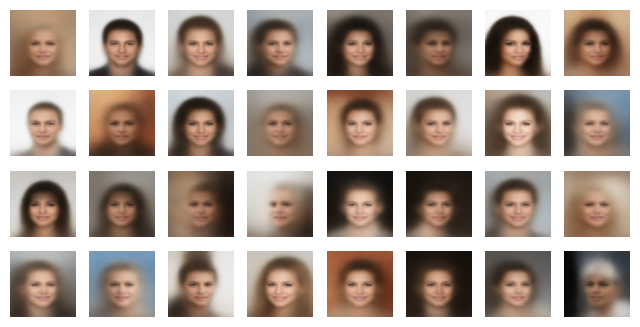

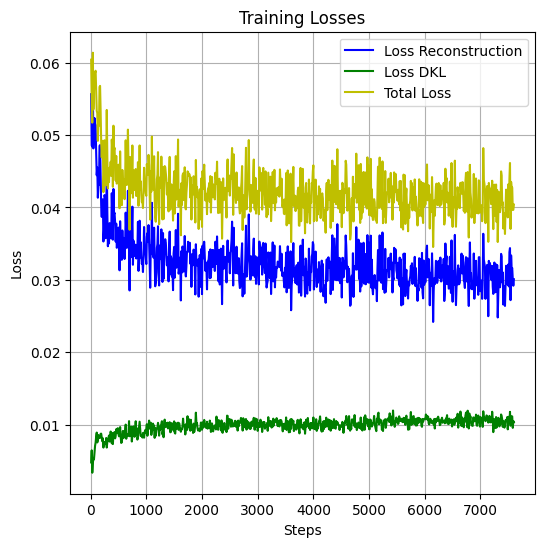

------------Losses---------------
loss_reconstruction:  tf.Tensor(0.030080419, shape=(), dtype=float32)
loss_dkl:  tf.Tensor(0.010310265, shape=(), dtype=float32)
total_loss:  tf.Tensor(0.040390685, shape=(), dtype=float32)
---------------------------------
Epoch: 14/15
N Batch: 5004
Step: 75900


100%|██████████| 15/15 [4:30:35<00:00, 1082.39s/it]


In [37]:
history = {
            'loss_reconstruction': [],
            'loss_sobel': [],
            'loss_dkl': [],
            'total_loss': []
        }

MSE = keras.losses.MeanSquaredError()
# SobelLoss = sobel_loss
optimizer = keras.optimizers.Adam()
total_epochs = 15
step = 0

for epoch in tqdm(range(total_epochs)):
    n_batch = 0
    for X_batch_1 in dataset_train:
        with tf.GradientTape() as tape:
            # Forward pass.
            X_reconstructions = variational_ae(X_batch_1)
            # Loss reconstruction
            loss_reconstruction = MSE(X_batch_1, X_reconstructions)
            # Loss sobel
            # loss_sobel = SobelLoss(X_batch_1, X_reconstructions, gamma=512.0)
            # Add extra loss terms to the loss value.
            loss_total = sum(variational_ae.losses) + loss_reconstruction #+ loss_sobel
        
        gradients = tape.gradient(loss_total, variational_ae.trainable_weights)
        optimizer.apply_gradients(zip(gradients, variational_ae.trainable_weights))
        
        if step % 100 == 0:
            
            history['loss_reconstruction'].append(loss_reconstruction)
            # history['loss_sobel'].append(loss_sobel)
            history['loss_dkl'].append(sum(variational_ae.losses))
            history['total_loss'].append(loss_total)
    
            generated_images = variational_ae(X_batch_1)
            plot_multiple_images(generated_images.numpy(), 8)
            plot_losses(history)
            print_logs(history, epoch, total_epochs, n_batch, step)
            plt.show()
        n_batch += 1
        step += 1


In [39]:
variational_ae.save('resnet_celeba_vae/autoencoder/vae_autoencoder.tf')
variational_encoder.save('resnet_celeba_vae/encoder/vae_encoder.tf')
variational_decoder.save('resnet_celeba_vae/decoder/vae_decoder.tf')

INFO:tensorflow:Assets written to: resnet_celeba_vae/autoencoder/vae_autoencoder.tf\assets


INFO:tensorflow:Assets written to: resnet_celeba_vae/autoencoder/vae_autoencoder.tf\assets


INFO:tensorflow:Assets written to: resnet_celeba_vae/encoder/vae_encoder.tf\assets


INFO:tensorflow:Assets written to: resnet_celeba_vae/encoder/vae_encoder.tf\assets


INFO:tensorflow:Assets written to: resnet_celeba_vae/decoder/vae_decoder.tf\assets


INFO:tensorflow:Assets written to: resnet_celeba_vae/decoder/vae_decoder.tf\assets
